## Изучение

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

### Загрузка данных

Для сокращения количества кода предобработки некоторые простые действия я сделал при чтении данных. А именно, преобразование строк в даты с помощью аргумента 'parse_dates' и написал простую лямбда-функцию cut_id (в следующей ячейке) для выделения значений 'id' из строк вида "{user_id}\_{id}". Я применил ее при чтении данных в качестве аргумента 'converters'.

In [2]:
cut_id = lambda x: int(x.split('_')[-1])

#### calls

In [3]:
calls = pd.read_csv(
    '/datasets/calls.csv', 
    parse_dates=['call_date'], 
    converters={'id': cut_id}
)
calls.head(5)

,id,call_date,duration,user_id
0,0,2018-07-25,0.00,1000
1,1,2018-08-17,0.00,1000
2,2,2018-06-11,2.85,1000
3,3,2018-09-21,13.80,1000
4,4,2018-12-15,5.18,1000


#### internet

Похоже эти данные были выгружены с индексами, поэтому я воспользовался аргументом 'index_col' при чтении.

In [4]:
internet = pd.read_csv(
    '/datasets/internet.csv', 
    index_col=0, 
    parse_dates=['session_date'],
    converters={'id': cut_id}
)
internet.head(5)

,id,mb_used,session_date,user_id
0,0,112.95,2018-11-25,1000
1,1,1052.81,2018-09-07,1000
2,2,1197.26,2018-06-25,1000
3,3,550.27,2018-08-22,1000
4,4,302.56,2018-09-24,1000


#### messages

In [5]:
messages = pd.read_csv(
    '/datasets/messages.csv',
    parse_dates=['message_date'],
    converters={'id':cut_id}
)
messages.head(5)

,id,message_date,user_id
0,0,2018-06-27,1000
1,1,2018-10-08,1000
2,2,2018-08-04,1000
3,3,2018-06-16,1000
4,4,2018-12-05,1000


#### tariffs

In [6]:
tariffs = pd.read_csv(
    '/datasets/tariffs.csv'
)
tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### users

In [7]:
users = pd.read_csv(
    '/datasets/users.csv',
    parse_dates=['churn_date', 'reg_date']
)
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Комментарий

Данные благополучно выгружены в таблицы. При загрузке данных я применил преобразование колонок с датами в тип datetime с помощью аргумента 'parse_dates'. Для колонки 'id' таблиц 'calls', 'internet', 'messages' применил собственный ковертер в виде лямбда функции для выделения значений 'id'.

### Изучение данных

#### calls

In [8]:
calls.info()
print('\nКоличество дубликатов:', calls.duplicated().sum())
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null int64
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.2 MB

Количество дубликатов: 0


,id,duration,user_id
count,202607.000000,202607.000000,202607.000000
mean,308.577181,6.755887,1253.940619
std,259.948786,5.843365,144.722751
min,0.000000,0.000000,1000.000000
25%,108.000000,1.300000,1126.000000
50%,243.000000,6.000000,1260.000000
75%,446.000000,10.700000,1379.000000
max,1759.000000,38.000000,1499.000000


In [9]:
print('Статистики звонков с нулевой продолжительностью')
calls.query('duration == 0').groupby('user_id')['duration'].count().agg(
    [
        'count', 
        'sum',
        'min',
        'median',
        'max'
    ]).reset_index(drop=True).rename(index={
        i: v for i, v in enumerate([
            'Количество пользователей',
            'Общее число звонков',
            'Минимальное количество звонков',
            'Медийное количество звонков',
            'Максимальное количество звонков'
        ])
    })

Статистики звонков с нулевой продолжительностью


Количество пользователей             492.0
Общее число звонков                39613.0
Минимальное количество звонков         5.0
Медийное количество звонков           66.0
Максимальное количество звонков      336.0
Name: duration, dtype: float64

Среди данных по звонкам наблюдаются звонки с нулевым временем разговора. Думаю это неотвеченные или нежелательные звонки (вроде предложений взять кредит или что-нибудь купить). Их количество примерно 20% от общего числа звонков. Я считаю, что их можно оставить и не трогать потому, что нужно изучить помесячную выручку от клиентов. Т.е. нужно будет группировать и суммировать значения продолжительности звонков, а нули сумму не изменят.  

#### internet

In [10]:
internet.info()
print('\nКоличество дубликатов:', internet.duplicated().sum())
internet.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null int64
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 5.7 MB

Количество дубликатов: 0


,id,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,205.811856,370.192426,1252.099842
std,157.267497,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,78.000000,138.187500,1130.000000
50%,172.000000,348.015000,1251.000000
75%,302.000000,559.552500,1380.000000
max,833.000000,1724.830000,1499.000000


In [11]:
print('Статистика соединений с нулевым трафиком')
internet.query('mb_used == 0').groupby('user_id')['mb_used'].count().agg(
    [
        'count', 
        'sum',
        'min',
        'median',
        'max'
    ]).reset_index(drop=True).rename(index={
        i: v for i, v in enumerate([
            'Количество пользователей',
            'Общее число соединений',
            'Минимальное количество соединений',
            'Медийное количество соединений',
            'Максимальное количество соединений'
        ])
    })

Статистика соединений с нулевым трафиком


Количество пользователей                494.0
Общее число соединений                19598.0
Минимальное количество соединений         1.0
Медийное количество соединений           31.0
Максимальное количество соединений      144.0
Name: mb_used, dtype: float64

In [12]:
round(19598 / 149396 * 100, ndigits=1)

13.1

В данных по использованному трафику есть соединения с нулевым расходом. Я думаю, что это связано с кэшированием, когда клиент посещает один и тот же ресурс, соединение устанавливается, но данные берутся из кэша. Здесь ситуация схожа с ситауцией по звонкам и так как нулевой трафик не влияет на конечную выручку от клиента его также можно оставить по тем же причинам.

#### messages

In [13]:
messages.info()
print('\nКоличество дубликатов:', messages.duplicated().sum())
messages.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null int64
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB

Количество дубликатов: 0


,id,user_id
count,123036.000000,123036.000000
mean,267.595281,1256.989410
std,248.577464,143.523967
min,0.000000,1000.000000
25%,81.000000,1134.000000
50%,195.000000,1271.000000
75%,379.000000,1381.000000
max,1462.000000,1499.000000


#### tariffs

In [14]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


#### users

In [15]:
users.info()
print('\nКоличество дубликатов:', users.duplicated().sum())
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB

Количество дубликатов: 0


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


### Выводы

- Колонки таблицы calls полностью заполнены значениями нужного формата без явных пропусков. Заметил наличие около 20% звонков с нулевой продолжительностью. Решение - оставить как есть звонки с нулевой продолжительностью, т.к. они не влияют на суммарное значение продолжительности звонков. 
- Колонки таблицы internet полностью заполнены значениями нужного формата без явных пропусков. Заметил наличие около 20% соединений с нулевым трафиком. Решение - оставить как есть строки с нулевым трафиком, т.к. они не влияют на суммарное значение трафика по пользователю. 
- Колонки таблицы messages полностью заполнены значениями нужного формата без явных пропусков. 
- Колонки таблицы tariffs полностью заполнены значениями нужного формата без пропусков - всего 2 строки.
- Колонки таблицы users полностью заполнены значениями нужного формата без явных пропусков, кроме колонки 'churn_date'. В ней всего 38 значений. Считаю, что только 38 клиентов прекратили пользоваться тарифом, а остальные продолжают исполльзовать свой тариф.
- Дубликаты не обнаружены.

## Предобработка

### Обработка даты

In [16]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

К данным по звонкам, трафику и сообщениям добавлены столбцы с обозначением месяца

### Округление

In [17]:
calls['duration'] = np.ceil(calls['duration'])
calls.head(5)

,id,call_date,duration,user_id,month
0,0,2018-07-25,0.0,1000,7
1,1,2018-08-17,0.0,1000,8
2,2,2018-06-11,3.0,1000,6
3,3,2018-09-21,14.0,1000,9
4,4,2018-12-15,6.0,1000,12


In [18]:
internet['mb_used'] = np.ceil(internet['mb_used'])
internet.head(5)

,id,mb_used,session_date,user_id,month
0,0,113.0,2018-11-25,1000,11
1,1,1053.0,2018-09-07,1000,9
2,2,1198.0,2018-06-25,1000,6
3,3,551.0,2018-08-22,1000,8
4,4,303.0,2018-09-24,1000,9


### Подготовка сводных таблиц

In [19]:
user_calls = calls.pivot_table(index=['user_id', 'month'], 
                  values='duration', 
                  aggfunc=['count', 'sum'])
user_calls.columns = pd.Index(['total_calls', 'total_call_time'])
user_calls.head(5)

total_calls  total_call_time
user_id month                              
1000    5               22            159.0
        6               43            172.0
        7               47            340.0
        8               52            408.0
        9               58            466.0

In [20]:
user_traffic = internet.groupby(['user_id', 'month'])[['mb_used']].sum()
user_traffic.columns = pd.Index(['total_mb'])
user_traffic.head(5)

total_mb
user_id month          
1000    5        2256.0
        6       23257.0
        7       14016.0
        8       14070.0
        9       14581.0

In [21]:
user_messages = messages.groupby(['user_id', 'month'])[['id']].count()
user_messages.columns = pd.Index(['total_messages'])
user_messages.head(5)

total_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

Посчитаны колчество звонков, потраченных минут, объем израсходованного трафика, количество сообщений по месяцам.

### Объединение сводных таблиц

In [22]:
# merging 'calls' and 'internet' tables
user_stats = user_calls.merge(user_traffic, 
                 how='outer',
                 left_index=True,
                 right_index=True
                )
# merging previous result with 'messages'
user_stats = user_stats.merge(user_messages,
                 how='outer',
                 left_index=True,
                 right_index=True
                )

In [23]:
# Fill NA after tables merging and transform dtypes
user_stats = user_stats.fillna(0).astype('int')
# merge 'user_stats' with 'users' to set tariffs for each row 
user_stats = user_stats.reset_index()
user_stats = user_stats.merge(users[['user_id', 'tariff']], on='user_id', how='left')
# Back MultiIndex
user_stats = user_stats.set_index(['user_id', 'month'])

In [24]:
user_stats.tail(10)

total_calls  total_call_time  total_mb  total_messages tariff
user_id month                                                               
1497    11              64              371     14174              14  smart
        12              71              545     19940              17  smart
1498    7               23              175      7486              20  smart
        8               57              400     24270              62  smart
        9               59              471     22166              44  smart
        10              41              247     20604              42  smart
1499    9                9               70      1848              11  smart
        10              68              449     17809              48  smart
        11              74              612     17984              59  smart
        12              69              492     13077              66  smart

После внешнего объединения таблиц могли возникнуть пропуски. Я заполнил их нулями - нули не повлияют на значение выручки. И это еще одино подтверждение вывода при изучении - оставить нулевые значения продолжительности звонков, расхода трафика.

### Звон монет или считаем выручку

In [25]:
# Define revenue function 
def calc_revenue(s_month, tariffs: pd.DataFrame):
    """Calculate revenue for user_stats row data"""
    
    tariff_name = s_month.at['tariff']
    tariff = tariffs.query("tariff_name == @tariff_name").iloc[0]

    user_fee = tariff['rub_monthly_fee']
    
    per_minute_fee  = tariff['rub_per_minute']
    per_message_fee = tariff['rub_per_message']
    per_gb_fee      = tariff['rub_per_gb']  
    
    minutes_over_limit  = max(0, s_month['total_call_time'] - tariff['minutes_included'])
    messages_over_limit = max(0, s_month['total_messages'] - tariff['messages_included'])
    traffic_over_limit  = max(0, s_month['total_mb'] - tariff['mb_per_month_included'])
    
    traffic_over_limit = np.ceil(traffic_over_limit / 1024) # convert in Gb
     
    revenue = user_fee + \
              minutes_over_limit * per_minute_fee + \
              messages_over_limit * per_message_fee + \
              traffic_over_limit * per_gb_fee
    
    return revenue

In [26]:
# Apply function 'calc_revenue' to data by rows
user_stats['revenue'] = user_stats.apply(calc_revenue, axis=1, args=[tariffs]).astype('int')

In [27]:
# Final pivot table
user_stats.head(15)

total_calls  total_call_time  total_mb  total_messages tariff  \
user_id month                                                                  
1000    5               22              159      2256              22  ultra   
        6               43              172     23257              60  ultra   
        7               47              340     14016              75  ultra   
        8               52              408     14070              81  ultra   
        9               58              466     14581              57  ultra   
        10              57              350     14717              73  ultra   
        11              43              338     14768              58  ultra   
        12              46              333      9827              70  ultra   
1001    11              59              430     18452               0  smart   
        12              63              414     14053               0  smart   
1002    6               15              117     10871               4  smart   
        7               26              214     17601              11  smart   
        8               42              289     20347              13  smart   
        9               36              206     16712               4  smart   
        10              33              212     13905              10  smart   

               revenue  
user_id month           
1000    5         1950  
        6         1950  
        7         1950  
        8         1950  
        9         1950  
        10        1950  
        11        1950  
        12        1950  
1001    11        1350  
        12         550  
1002    6          550  
        7         1150  
        8         1550  
        9          950  
        10         550

### Выводы

- Из данных по звонкам и трафику удалены строки с нулевыми значениями продолжительности разговора и потраченных мегабайт.
- Подготовлена к анализу сводная таблица по количеству звонков, потраченным минутам, объему трафика, количеству сообщений по месяцам. 
- Посчитана и добавлена в таблицу помесячная выручка по каждому клиенту. 

## Анализ

Нужно описать помесячные расходы минут, трфика и сообщений клиентов по каждому тарифу. Я понимаю это так:  нужно описать характерные расходы среднего пользователя. Поэтому найдем средние показатели для каждого пользователя, а затем на основе этих данных опишем всех пользователей в среднем (т.е. общее среднее по набору средних для каждого пользователя).

In [28]:
smart_stats = user_stats.query('tariff == "smart"').groupby(level=0).median()
ultra_stats = user_stats.query('tariff == "ultra"').groupby(level=0).median()

In [29]:
analysed_cols = ['total_call_time', 'total_mb', 'total_messages']

### Анализ тарифа smart

       total_call_time  total_mb  total_messages
count            350.0     350.0           350.0
mean             437.0   16854.0            34.0
std              160.0    4180.0            28.0
min                0.0    5545.0             0.0
25%              324.0   14204.0            11.0
50%              440.0   16948.0            28.0
75%              541.0   19325.0            51.0
max              892.0   36319.0           134.0

                     Variance
total_call_time       25685.0
total_mb           17468577.0
total_messages          785.0
dtype: float64


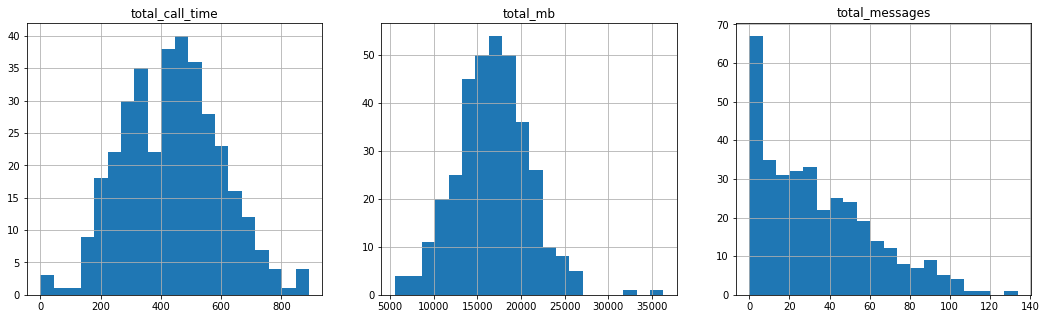

In [30]:
print(smart_stats[analysed_cols].describe().round(), '', sep='\n')
print(f'{"Variance":>29}', smart_stats[analysed_cols].var().round(), sep='\n')

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

for col, ax in zip(analysed_cols, axes):
    ax.set_title(col)
    smart_stats[col].hist(bins=20, ax=ax)

- Средний пользователь тарифа 'смарт' в среднем тратит 415 минут разговора, 17Гб трафика, 28 сообщений в месяц.
- В среднем больше чуть половины пользователей выходят за рамки беслпатного трафика
- Есть клиенты, которые в среднем расходуют более 30 Гб трафика в месяц - выбросы на среднем графике.
- Большинство пользователей не пользуются смс или пользуются редко. Мне кажется число сообщений можно считать распределением Пуассона, где за время или количество экспериментов можно считать пользователей, а событием - отправку смс. На остальных графиках - нормальное распределение.
- На графике 'total_call_time' как будто прослеживается бимодальное распределение (т.е. можно выделить две группы клиентов, те кто говорит побольше и поменьше), но мне кажется это с погрешностью можно считать нормальным (если увеличить количество график станет нормальным). Это можно отдельно исследовать. Этому нас по-моему не учили.
- Около четверти клиентов тарифа 'смарт' превышают лимит минут и смс.

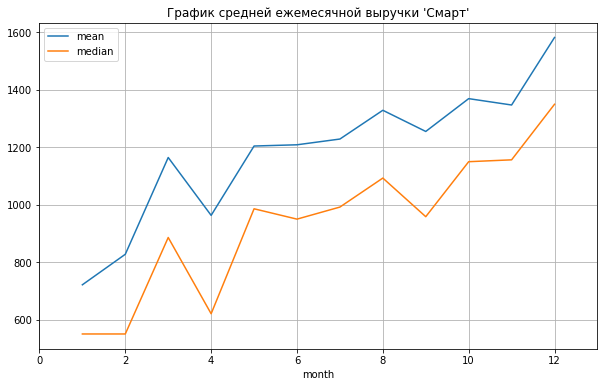

In [31]:
mid_monthly_revenue = user_stats.query('tariff == "smart"').groupby(level=1)['revenue'].agg(['mean', 'median'])
mid_monthly_revenue.plot(
    grid=True,
    xlim=(0, 13), 
    figsize=(10, 6), 
    title="График средней ежемесячной выручки 'Смарт'"
)
print(end='')

Наблюдается ежемесячный рост средней выручки за счет новых клиентов.

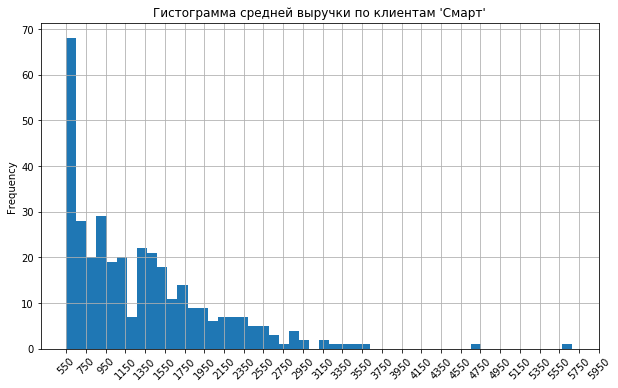

In [32]:
# fig, axes = plt.subplots(ncols=2, figsize=(28, 10))
xticks = list(range(550, 6000, 200))
smart_stats['revenue'].plot.hist(
    bins=50, 
    grid=True, 
    figsize=(10, 6), 
    xticks=xticks, 
    rot=45,
    title="Гистограмма средней выручки по клиентам 'Смарт'",
)
print(end='')

Два выброса - клиенты превысившие лимиты трафика более, чем на 30 Гб, примерно в полтора раза лимиты минут и один еще и смс больше на 33 отправил.

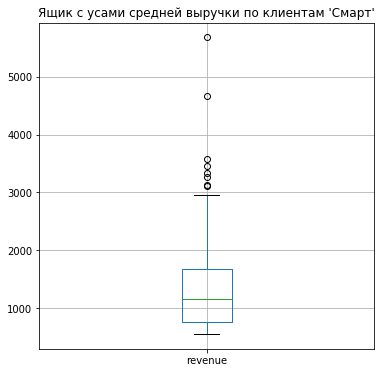

In [33]:
smart_stats['revenue'].plot.box(
    grid=True, 
    figsize=(6, 6), 
    title="Ящик с усами средней выручки по клиентам 'Смарт'"
)
print(end='')

На самом деле выбросов больше двух.

In [34]:
smart_stats.query("revenue > 3000")

,total_calls,total_call_time,total_mb,total_messages,revenue
user_id,,,,,
1042,72.0,430.5,22084.0,45.0,3129.5
1047,116.0,762.0,26192.0,66.0,3584.0
1229,112.0,672.0,25033.0,5.0,3266.0
1261,117.0,738.0,32542.0,22.0,4664.0
1313,126.0,853.0,21673.0,28.0,3342.0
1456,112.0,889.0,22288.0,0.0,3117.0
1462,126.0,878.0,23395.0,0.0,3449.0
1486,108.0,764.0,36319.0,83.0,5680.0


Думаю это те люди, которые ошиблись тарифом, им бы больше подошел 'Ультра'.
Да и вообще по большому хвосту справа на гистограмме видно, что большинство не укладывается в тарифные лимиты.

In [35]:
ntotal_smart = smart_stats.shape[0]
nover_limit_smart = smart_stats.query("revenue > 550").shape[0]
print("Общее число пользователей 'Смарт':", ntotal_smart)
print("Количество клиентов, превышающих тарифные лимиты 'Смарт':", nover_limit_smart)
print("Доля клиентов, превышающих тарифные лимиты 'Смарт': {:,.0%}".format(nover_limit_smart / ntotal_smart))

Общее число пользователей 'Смарт': 350
Количество клиентов, превышающих тарифные лимиты 'Смарт': 302
Доля клиентов, превышающих тарифные лимиты 'Смарт': 86%


In [36]:
print("Характеристики выручки тарифа 'Смарт'.")
print("Общая выручка за все время: {:,} руб.".format(user_stats.query("tariff == 'smart'")['revenue'].sum()))
print("""\
Среднее: {:,.0f} руб.
Стандартное отклонение: {:,.0f} руб.
Дисперсия: {:,.0f} руб.""".format(*smart_stats['revenue'].agg(['median', 'std', 'var'])))
print("Общая выручка на 1 клиента в среднем: {:,.0f} руб".format(
    user_stats.query("tariff == 'smart'").groupby(level=0)['revenue'].sum().median()
))


Характеристики выручки тарифа 'Смарт'.
Общая выручка за все время: 2,885,751 руб.
Среднее: 1,150 руб.
Стандартное отклонение: 724 руб.
Дисперсия: 524,720 руб.
Общая выручка на 1 клиента в среднем: 7,290 руб


* Наблюдается ежемесячный рост средней выручки за счет новых клиентов (для данной выборки)
* Гистограмма скошена вправо. 86% клиентов 'Смарт' превышают тарифные лимиты.
* средняя выручка 1,150 руб, стандартное отклонение 724 руб, дисперсия 524,720 руб
* Общая выручка на 1 клиента в среднем: 7,290 руб

### Анализ тарифа ultra

       total_call_time  total_mb  total_messages
count            148.0     148.0           148.0
mean             558.0   20322.0            57.0
std              304.0    8901.0            49.0
min                0.0       0.0             0.0
25%              336.0   14699.0            17.0
50%              535.0   19750.0            48.0
75%              786.0   27234.0            87.0
max             1273.0   39230.0           197.0

                     Variance
total_call_time       92291.0
total_mb           79230804.0
total_messages         2424.0
dtype: float64


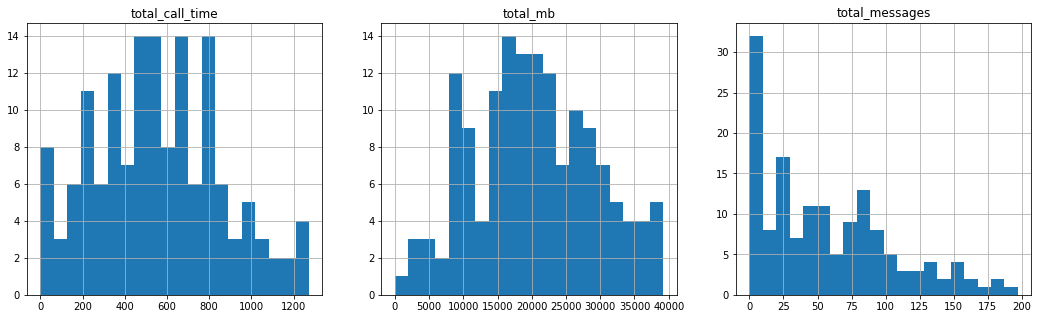

In [37]:
print(ultra_stats[analysed_cols].describe().round(), '', sep='\n')
print(f'{"Variance":>29}', ultra_stats[analysed_cols].var().round(), sep='\n')

fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

for col, ax in zip(analysed_cols, axes):
    ax.set_title(col)
    ultra_stats[col].hist(bins=20, ax=ax)

- Средний пользователь тарифа 'ультра' в среднем тратит 507 минут разговора, 20Гб трафика, 48 сообщений в месяц.
- Распределение средней длительности звонков клиентов тарифа 'ультра' можно считать нормальным. Будет стремиться к нормальному по ЦПТ с увеличением выборки. Ни один абонент не превышает лимита отпущенных минут :-) Клиенты испльзуют меньше половины предоставленных тарифом минут. Хватает с запасом.
- Примерно четверть клиентов превышает лимит использования трафика
- Большинство не шлет смс. Хотя максимальное количество смс в этом тарифе больше, чем в 'смарт'.
- Все пользователи тарифа тратят не более 20% ресурса смс. Хватает с большим запасом.

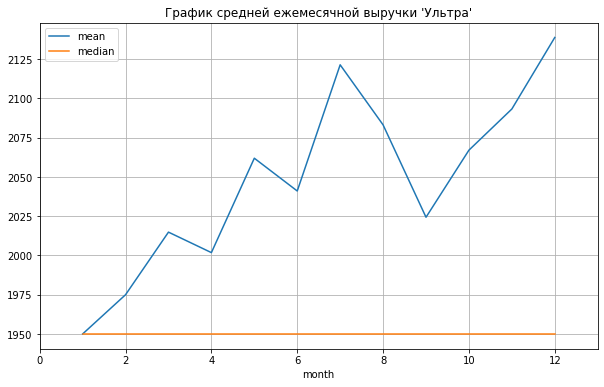

In [38]:
mid_monthly_revenue = user_stats.query('tariff == "ultra"').groupby(level=1)['revenue'].agg(['mean', 'median'])
mid_monthly_revenue.plot(
    grid=True,
    xlim=(0, 13), 
    figsize=(10, 6), 
    title="График средней ежемесячной выручки 'Ультра'"
)
print(end='')

- Медиана помесячной выручки лежит... Т.е. устойчиво себя ведет от месяца к месяцу. Она вообще константа.
- Наблюдаю более резкие скачки среднего, чем для смарт- в сторону повышения выручки. Очень резкий спад выручки в сентябре. Можно придумать гипотезу, что до сентября клиенты больше тратили в отпуске, а после перед новым годом. Это может быть сезонность, но для исследования нужна гораздо большая выборка за несколько лет. 

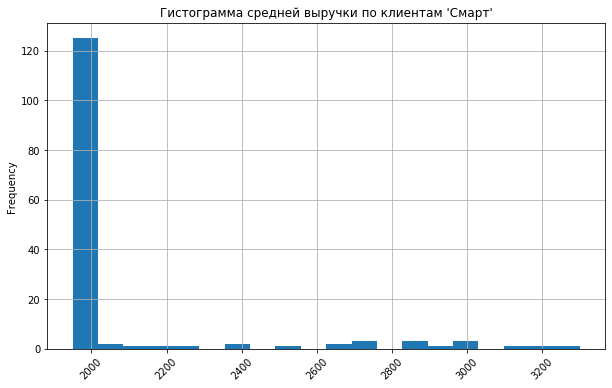

In [39]:
# fig, axes = plt.subplots(ncols=2, figsize=(28, 10))
xticks = list(range(550, 6000, 200))
ultra_stats['revenue'].plot.hist(
    bins=20, 
    grid=True, 
    figsize=(10, 6), 
#     xticks=xticks, 
    rot=45,
    title="Гистограмма средней выручки по клиентам 'Смарт'",
)
print(end='')

Гистограмма скошена вправо. По ней видно, что, превышающих лимиты, клиентов мало, и в основном клиентам 'Ультра' хватает пакета

In [40]:
ntotal_ultra = ultra_stats.shape[0]
nover_limit_ultra = ultra_stats.query("revenue > 1950").shape[0]
print("Общее число пользователей 'Ультра':", ntotal_ultra)
print("Количество клиентов, превышающих тарифные лимиты 'Ультра':", nover_limit_ultra)
print("Доля клиентов, превышающих тарифные лимиты 'Ультра': {:,.0%}".format(nover_limit_ultra / ntotal_ultra))

Общее число пользователей 'Ультра': 148
Количество клиентов, превышающих тарифные лимиты 'Ультра': 23
Доля клиентов, превышающих тарифные лимиты 'Ультра': 16%


In [41]:
print("Характеристики выручки тарифа 'Ультра'.")
print("Общая выручка за все время: {:,} руб.".format(user_stats.query("tariff == 'ultra'")['revenue'].sum()))
print("""\
Среднее: {:,.0f} руб.
Стандартное отклонение: {:,.0f} руб.
Дисперсия: {:,.0f} руб.""".format(*ultra_stats['revenue'].agg(['median', 'std', 'var'])))
print("Общая выручка на 1 клиента в среднем: {:,.0f} руб".format(
    user_stats.query("tariff == 'ultra'").groupby(level=0)['revenue'].sum().median()
))


Характеристики выручки тарифа 'Ультра'.
Общая выручка за все время: 2,040,000 руб.
Среднее: 1,950 руб.
Стандартное отклонение: 300 руб.
Дисперсия: 90,191 руб.
Общая выручка на 1 клиента в среднем: 13,725 руб


* Средняя выручка стабильна во всех месяцах
* Гистограмма скошена вправо. 16% клиентов 'Ультра' превышают тарифные лимиты.
* средняя выручка 1,950 руб, стандартное отклонение 300 руб, дисперсия 90,191 руб
* Общая выручка на 1 клиента в среднем: 13,725 руб

### Выводы

- Пользователи тарифа 'смарт' гораздо чаще превышают лимиты: около 25% клиентов превышают лимиты звонков и смс и около половины превышают лимит трафика. Причем лимиты звонков превышаются примерно в 1.5 раза, а  лимиты трафика максимально более чем в два раза.
- Четверть 'ультра'-клиентов превышают лимит трафика. Но остальных ресурсов остается с запасом.
- В целом пользователи чаще пользуются интернетом, затем звонками сотовой сети и реже смс.
- Разброс значений (std) по все трем показателям у клиентов 'ультра' примерно в 2 раза больше клиентов 'смарт'
- Средняя выручка с клиентов Смарт не стабильна от месяца к месяцу.
- 86% клиентов 'Смарт' превышают тарифные лимиты.

Характеристики выручки|тариф 'Смарт'|тариф 'Ультра'
---|---|---
Общая выручка за все время| 2,885,751 руб|2,040,000 руб
Среднее| 1,150 руб|1,950 руб
Стандартное отклонение| 724 руб|300 руб
Дисперсия| 524,720 руб|90,191 руб
Общая выручка на 1 клиента в среднем| 7,290 руб|13,725 руб 

- Тариф 'Ультра' стоит дороже, приносит выручки в среднем больше, выручка относительно стабильна, разброс значений относительно 'Смарт' меньше, клиентов относительно 'Смарт' меньше.
- Здесь уже можно сказать, что департаменту рекомендуется заниматься тарифом 'Смарт'. Т.к. клиентам этого тарифа явно не хватает пакета, есть клиенты, которые сильно превышают лимиты и наблюдается гораздо больший, чем в 'Ультра', разброс значений.

## Проверка гипотез

### Сравнение средних выручек по тарифам

Так как проверяю гипотезу о равенстве средних (гипотеза 0: =; гипотеза 1: !=) двух выборок, использовать буду Т-тест с двусторонним критерием. Если попали статистикой в доверительную область, то нулевую гипотезу отвергнуть НЕ удалось, если в критическую - отвергаем нулевую гипотезу. Попадание в критическую область определяется с помощью p-value, если оно меньше уровня значимости значит мы в критической области. Еще одна интерпретация: посчитанное значение статистики Т-теста по модулю превзашло критическое значение соответствующее уровню значимости. Еще можно по площадям объяснить, но это удобнее рисовать.

In [43]:
print('Нулевая гипотеза: средние выручки тарифов smart и ultra равны')
print('Альтернативная гипотеза: средние выручки от клиентов smart и ultra НЕ равны')
print()

alpha = .05
result = st.stats.ttest_ind(smart_stats['revenue'], ultra_stats['revenue'], equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print("Средняя выручка тарифа 'смарт':", smart_stats['revenue'].median().round())
print("Средняя выручка тарифа 'ультра':", ultra_stats['revenue'].median())

Нулевая гипотеза: средние выручки тарифов smart и ultra равны
Альтернативная гипотеза: средние выручки от клиентов smart и ultra НЕ равны

p-значение: 1.457472875153576e-48
Отвергаем нулевую гипотезу
Средняя выручка тарифа 'смарт': 1150.0
Средняя выручка тарифа 'ультра': 1950.0


### Сравнение средних выручек по регионам

In [44]:
uid_moscow = users.query("city == 'Москва'").set_index('user_id').index
uid_regions = users.set_index('user_id').index.difference(uid_moscow)

In [45]:
revenue_moscow = user_stats.query('user_id.isin(@uid_moscow)')['revenue']
revenue_regions = user_stats.query('user_id.isin(@uid_regions)')['revenue']

In [46]:
print('Нулевая гипотеза: средние выручки от клиентов Москвы и регионов равны')
print('Альтернативная гипотеза: средние выручки от клиентов Москвы и регионов НЕ равны')
print()

alpha = .05
result = st.stats.ttest_ind(revenue_moscow, revenue_regions, equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

print("Средняя выручка по Москве:", revenue_moscow.median())
print("Средняя выручка по регионам:", revenue_regions.median())

Нулевая гипотеза: средние выручки от клиентов Москвы и регионов равны
Альтернативная гипотеза: средние выручки от клиентов Москвы и регионов НЕ равны

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу
Средняя выручка по Москве: 1750.0
Средняя выручка по регионам: 1587.0


### Выводы

- Средние выручки от клиентов по разным тарифам - не равны. Среднемесячная выручка от клиентов с тарифом 'ультра' больше, чем от клиентов 'смарт'
- Средние выручки от клиентов по Москве и регионам статистически равны. 

## Общие выводы

- Клиенты с тарифом 'ультра' - запасливые люди, покупают больше, чем тратят. Лимит превышается только на пользование трафиком. 
- Клиенты с тарифом 'смарт' - скорее всего стараются сэкономить, но большенству нужно больше предоставляемых ресурсов. Клиенты во всех категориях превышают лимиты.
- Вариация расходов у клиентов 'ультра' шире, чем у 'смарт'.
- Средние выручки от клиентов по разным тарифам - не равны. Среднемесячная выручка от клиентов с тарифом 'ультра' больше, чем от клиентов 'смарт'
- Средние выручки от клиентов по Москве и регионам статистически равны.
- Средняя выручка с клиентов Смарт не стабильна.
- 86% клиентов 'Смарт' превышают тарифные лимиты.
- Тариф 'Ультра' стоит дороже, приносит выручки на 1 клиента в среднем больше, выручка относительно стабильна, разброс значений относительно 'Смарт' гораздо меньше, клиентов относительно 'Смарт' меньше.
- Департаменту рекомендуем заниматься тарифом 'Смарт'. Т.к. клиентам этого тарифа явно не хватает пакета, есть клиенты, которые сильно превышают лимиты и наблюдается гораздо больший, чем в 'Ультра', разброс значений.
    